# CNN: UNet with ResNet 101 backbone


I train a UNet model for the barnacle segmentation problem. Though it excels at semantic segmenation better than instance segmentation, I intend to add a watershed pipeline (or similar) to separate unavoidable clustering of detected barnacles.

I cleaned up this approach from an earlier trial and error where I trained a UNet++ model on the MonuSeg database and then progressively fine-tuned on a the smaller dataset of barnacle tiles.

I used augmentation here to make up for the small dataset, and increased the overlap between tiles. An overlap of 4-8 pixels begun to show overfitting since the model was reintroduced the same tiles repeatedly.

My standard tiling routine which I adapted slightly to increase the number of tiles to train the UNet model. As a CNN, I would expect better performance with more tiles, but I had to balance the risk of overfitting.

In [5]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [6]:
from google.colab import drive
drive.mount('/content/drive')

!rm -r tiles
!mkdir -p tiles/images tiles/masks

TILE_SIZE, OVERLAP = 128, 16 # 128x128 tiles

for i in range(1, 3):
    path0 = f'drive/MyDrive/data/img{i}_nice.png'
    path1 = f'drive/MyDrive/data/mask{i}.png'

    image = cv2.imread(path0, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    # Convert outlines mask to white outlines with black background
    mask = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 1)
    mask = cv2.bitwise_not(mask)

    # kernel = np.ones((1, 1), np.uint8)
    # thicker = cv2.dilate(mask, kernel, iterations=1)

    # # Morphological closing to seal small holes and gaps
    # closed = cv2.morphologyEx(thicker, cv2.MORPH_CLOSE, kernel, iterations=1)

    # # Flood fill from corners
    # floodfilled = closed.copy()
    # h, w = closed.shape
    # mask_ff = np.zeros((h + 2, w + 2), np.uint8)
    # for seed in [(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)]:
    #     cv2.floodFill(floodfilled, mask_ff, seed, 255)

    # floodfilled_inv = cv2.bitwise_not(floodfilled)
    # mask = cv2.bitwise_or(closed, floodfilled_inv)

    height, width = image.shape[:2]
    j = 0
    for top in range(0, height - TILE_SIZE + 1, OVERLAP):
        for left in range(0, width - TILE_SIZE + 1, OVERLAP):
            tile0 = image[top : top + TILE_SIZE, left : left + TILE_SIZE]
            tile1 = mask[top : top + TILE_SIZE, left : left + TILE_SIZE]

            # Ignore tiles that are 95% black (empty)
            if (np.sum(tile0 < 5)) / (TILE_SIZE ** 2) > 0.95: # keep empty tiles to learn edges better
                continue

            cv2.imwrite(os.path.join('tiles/images', f'tile_{i}_{j}.png'), tile0)
            cv2.imwrite(os.path.join('tiles/masks', f'tile_{i}_{j}.png'), tile1)

            j += 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Do an 80-20 split of heavily augmented data.

In [ ]:
# Custom Dataset
class BarnaclesDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        image = Image.open(self.image_paths[i]).convert("RGB")
        mask = Image.open(self.mask_paths[i]).convert("L")

        # apply augmentations to the dataset
        if self.augment:
            # horizontal
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            # vertical
            if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)
            # rotate
            angle = random.randint(-20, 20)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = (mask > 0.5).float()  # binarize just in case

        return image, mask


 # split into 80-20 train and validation split
image_dir = 'tiles/images'
mask_dir = 'tiles/masks'
image_paths = sorted([os.path.join(image_dir, name) for name in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, name) for name in os.listdir(mask_dir)])
train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

train_dataset = BarnaclesDataset(train_imgs, train_masks, augment=True)
val_dataset = BarnaclesDataset(val_imgs, val_masks, augment=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [35]:
# adapted from https://github.com/milesial/Pytorch-UNet

import torch.nn.functional as F
import torch.utils.checkpoint

class Double(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            Double(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = Double(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = Double(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = Double(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = Out(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

I was concerned about overfitting, so I track the dice coefficient over epochs and if it doesn't improve over the average for 2 epochs then I reduce the learning rate by using ReducedLROnPlateau. This ensures that the size of the initial learning rate doesn't lead to an undertrained model. If it doesn't improve for 3 epochs, I implement a rudimentary early stop - though I know there may be more PyTorch-native ways to do this. I use binary cross entropy over dice loss and a combination of the two as the loss function.

In [36]:
# Dice coefficient
def dice_coeff(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch=1: Train loss=0.1477, Test loss=0.1437, Dice=0.7237
New model saved (epochs=1)

Epoch=2: Train loss=0.1414, Test loss=0.1320, Dice=0.7497
New model saved (epochs=2)

Epoch=3: Train loss=0.1353, Test loss=0.1300, Dice=0.7532
New model saved (epochs=3)

Epoch=4: Train loss=0.1316, Test loss=0.1286, Dice=0.7570
New model saved (epochs=4)

Epoch=5: Train loss=0.1267, Test loss=0.1193, Dice=0.7848
New model saved (epochs=5)

Epoch=6: Train loss=0.1225, Test loss=0.1140, Dice=0.7921
New model saved (epochs=6)

Epoch=7: Train loss=0.1191, Test loss=0.1078, Dice=0.8077
New model saved (epochs=7)

Epoch=8: Train loss=0.1161, Test loss=0.1091, Dice=0.8028

Epoch=9: Train loss=0.1119, Test loss=0.1072, Dice=0.8053

Epoch=10: Train loss=0.1103, Test loss=0.1046, Dice=0.8091
New model saved (epochs=10)


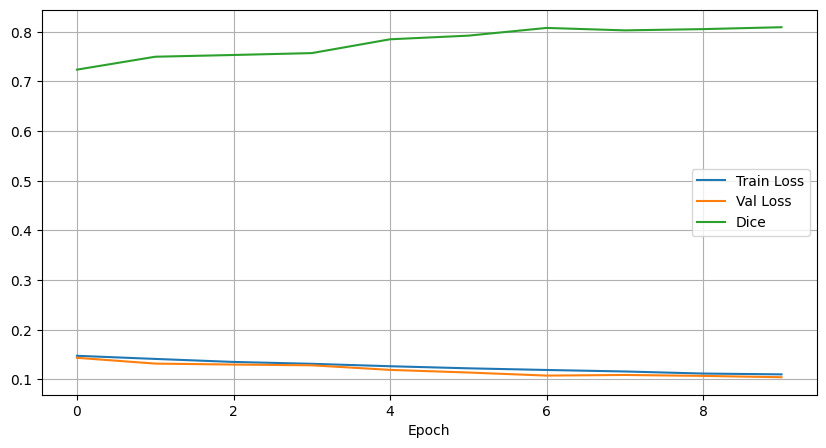

In [46]:
EPOCHS = 10 # run for 20 epochs in the notebook
PATIENCE = 3

model = UNet(n_channels=3, n_classes=1)

if os.path.exists('best_model.pth') and input('Load pretrained weights? ') == 'y':
  model.load_state_dict(torch.load("best_model.pth", map_location='cpu'))

model = model.to('cuda')
criterion = nn.BCEWithLogitsLoss() # binary cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

best_dice = 0
best_model_path = 'best_model.pth'
patience = PATIENCE # track epochs without improvement

# track loss and dice for to draw graph later
train_losses, val_losses, dices = [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to('cuda'), masks.to('cuda')
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    dice_total = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to('cuda'), masks.to('cuda')
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            dice_total += dice_coeff(outputs, masks)

    val_loss /= len(val_loader)
    avg_dice = dice_total / len(val_loader) # track average validation dice

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    dices.append(avg_dice)

    print(f'\nEpoch={epoch+1}: Train loss={train_loss:.4f}, Test loss={val_loss:.4f}, Dice={avg_dice:.4f}')

    scheduler.step(val_loss)

    # Early stopping
    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(model.state_dict(), best_model_path)
        print(f'New model saved (epochs={epoch+1})')
        patience = PATIENCE # restore patience
    else:
        patience -= 1
        if patience == 0:
            print(f'Early stop (epochs={epoch+1})')
            break

# plot metrics
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot(dices, label='Dice')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


Run inference on a cropped segment of unseen_img2 to see how it is performing.

The model's predicted mask contains incomplete and connected outlines. The former can be solved by morphologically closing the contours. The latter can be solved with a watershed approach. I only count connected components in the binary mask for simplicity and discarded those that were too small.

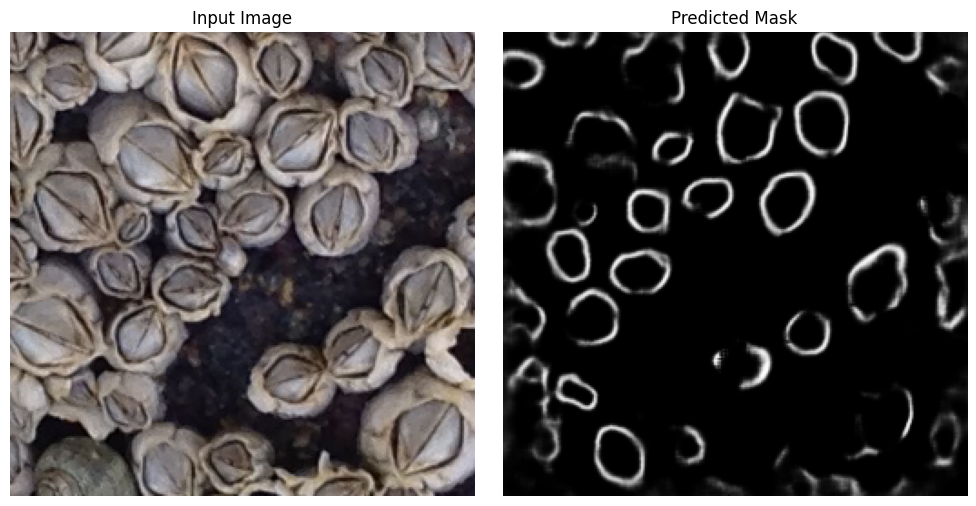

35 barnacles detected


In [47]:
model.eval()


image_path = "unseen_img2_cropped.png"
image = Image.open(image_path).convert("RGB")
input = TF.to_tensor(image).unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input.to(device)
model = model.to(device)

# Run inference
with torch.no_grad():
    output = model(input)
    pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
    binary_mask = (pred_mask).astype('float32')


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# apply connected components analysis on count of outlines

mask = (binary_mask * 255).astype('uint8')
_, thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, _, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=8)

# filter by area
min_area = 50
n = np.sum(stats[1:, cv2.CC_STAT_AREA] >= min_area)
print(f"{n} barnacles detected")


This pipeline could be improved with more robust image postprocessing to count the number of barnacles accurately. Alternatively, an ensemble with the Cellpose model or analysing barnacle candidates' properties (like area and eccentricity) and training an XGBoost model on them for actual outlines might also help.